In [1]:
!pip install easyfsl
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average


Defaulting to user installation because normal site-packages is not writeable


/data/asufian/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import os
import random
from collections import defaultdict
from PIL import Image, ImageOps
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class PrototypicalOmniglotDataset(Dataset):
    def __init__(self, root, num_classes=1623, n_shot=5, n_query=10, transform=None):
        self.root = root
        self.num_classes = num_classes
        self.n_shot = n_shot
        self.n_query = n_query
        self.transform = transform
        self.samples_by_label = defaultdict(list)
        self.all_imgs = {}
        self.classes = []

        # Common image file extensions
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp']

        # Organize data into classes and image paths
        for alphabet in os.listdir(self.root):
            alphabet_path = os.path.join(self.root, alphabet)
            if not os.path.isdir(alphabet_path):
                continue

            for char_class in os.listdir(alphabet_path):
                char_class_path = os.path.join(alphabet_path, char_class)

                # Skip if the entry is not a directory
                if not os.path.isdir(char_class_path):
                    continue

                all_images = []
                for img_name in os.listdir(char_class_path):
                    img_path = os.path.join(char_class_path, img_name)

                    # Check if it's a file with a recognized image extension
                    if os.path.isfile(img_path) and any(img_name.lower().endswith(ext) for ext in image_extensions):
                        all_images.append(img_path)

                if all_images:
                    char_class_name = f"{alphabet}_{char_class}"
                    self.samples_by_label[char_class_name] = list(range(len(all_images)))
                    self.all_imgs[char_class_name] = all_images
                    self.classes.append(char_class_name)

    def transform_image(self, raw_img):
#         img = ImageOps.invert(raw_img)
#         if self.transform is not None:
        img = self.transform(raw_img)
        return img

    def __getitem__(self, index):
        selected_classes = random.sample(self.classes, self.num_classes)
        class_indices = [self.samples_by_label[each_cls] for each_cls in selected_classes]

        support_set = []
        query_set = []
        label_id = 0
        qs=[]
        for idx_set in class_indices:
            # Creating support set
            selected_support = random.sample(idx_set, self.n_shot)
            support_images = [self.transform_image(Image.open(self.all_imgs[selected_classes[label_id]][each]).convert('RGB')) for each in selected_support]

            # Creating query set
            selected_query = random.sample(idx_set, self.n_query)
            query_images = [self.transform_image(Image.open(self.all_imgs[selected_classes[label_id]][each]).convert('RGB')) for each in selected_query]
            support_set.append((support_images, [label_id for _ in range(self.n_shot)]))
            # print("aaaaaaaaaa",label_id)
            query_set.append((query_images,  [label_id for _ in range(self.n_query)]))

            label_id += 1
            # qs= [item for item in a for _ in range(self.n_query)]
        return support_set, query_set

    def __len__(self):
        return 10

# Set up the transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
])

# Set up the SiameseOmniglotDataset
# Training == evaluation
root_path = './final_training_processed_data'
num_classes = 5  # Set the desired number of classes per episode
n_shot = 5
n_query = 10

PrototypicalOmniglotDatasetLoader = PrototypicalOmniglotDataset(root=root_path, num_classes=num_classes, n_shot=n_shot, n_query=n_query, transform=transform)


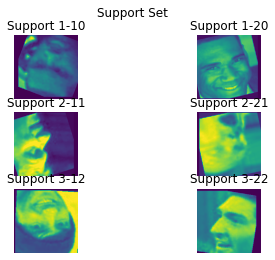

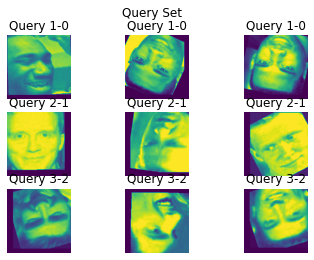

In [6]:
transform = transforms.Compose([
    transforms.Resize((200, 200)),  # Resize to expected size
    transforms.RandomRotation(degrees=30),  # Random rotation to address orientation issues
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomVerticalFlip(p=0.5),    # Random vertical flip
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Stronger color jitter to account for color variation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation for slight shift
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization (adjust if needed)
])

# Set up the PrototypicalOmniglotDatasetLoader
root_path ='./final_training_processed_data'# '/path/to/omniglot_dataset'
num_classes = 3
n_shot = 2
n_query = 3

dataset = PrototypicalOmniglotDataset(root=root_path, num_classes=num_classes, n_shot=n_shot, n_query=n_query, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a PrototypicalNetwork model
# model = PrototypicalNetwork(num_classes=num_classes).to(device)

# Set the model to evaluation mode
# model.eval()

# Choose an episode to visualize
episode_index = 10  # Change this to the desired episode index

# Get support set and query set for the chosen episode
support_set, query_set = dataset[episode_index]

# Visualize support set
for i, (support_images, lbl) in enumerate(support_set):
    for j, img in enumerate(support_images):
        plt.subplot(len(support_set), len(support_images), i * len(support_images) + j + 1)
        plt.imshow(img[0] )  # Assuming the image is grayscale
        plt.axis('off')
        plt.title(f'Support {i + 1}-{j + 1}{lbl[j]}')

plt.suptitle('Support Set')
plt.show()

# Visualize query set
for i, (query_images, ll) in enumerate(query_set):
    for j, img in enumerate(query_images):
        plt.subplot(len(query_set), len(query_images), i * len(query_images) + j + 1)
        plt.imshow(img[0])  # Assuming the image is grayscale
        plt.axis('off')
        plt.title(f'Query {i + 1}-{ll[j]}')

plt.suptitle('Query Set')
plt.show()


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import ViTImageProcessor, ViTModel
import torchvision.models as models

class ResNet18WithDropout(nn.Module):
    def __init__(self, pretrained=False, dr=0.5):
        super(ResNet18WithDropout, self).__init__()
        self.resnet18 = models.resnet18(pretrained=pretrained)
        self.dropout = nn.Dropout(dr)
        num_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(num_features, 1000)  # Example output size

    def forward(self, x):
        x = self.resnet18(x)
        x = self.dropout(x)
        return x

Total parameters: 101121536
Learnable parameters: 13353312
torch.Size([4, 3])


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from transformers import AutoFeatureExtractor, ViTForImageClassification
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import ViTImageProcessor, ViTModel
import torchvision.models as models

class ResNet18WithDropout(nn.Module):
    def __init__(self, pretrained=False, dr=0.5):
        super(ResNet18WithDropout, self).__init__()
        self.resnet18 = models.resnet18(pretrained=pretrained)
        self.dropout = nn.Dropout(dr)
        num_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(num_features, 1000)  # Example output size

    def forward(self, x):
        x = self.resnet18(x)
        x = self.dropout(x)
        return x
# Define the transformation to resize images to 224x224
resize_transform = transforms.Resize((224, 224))

class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module, combined_dim: int, dropout_rate: float = 0.5):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone
        
        # Initialize ViT feature extractor and model
        self.feature_extractor = AutoFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
        self.vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

        # Freeze the weights of the ViT model
        self.freeze_vit()

        # FC layers with dropout
        self.fc = nn.Sequential(
            nn.Linear(combined_dim, 500),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(500, 300)
        )

    def freeze_vit(self):
        for param in self.vit_model.parameters():
            param.requires_grad = False

    def rescale_to_vit_range(self, images: torch.Tensor) -> torch.Tensor:
        """
        Rescale image tensor to [0, 1] for ViT input.
        """
        images_rescaled = (images - images.min()) / (images.max() - images.min())
        return images_rescaled

    def forward(self, support_images, support_labels, query_images: torch.Tensor) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        num_classes = len(support_labels)
        combined_prototypes = []

        for class_label in range(num_classes):
            support_images_eachclass = support_images[class_label]

            # Resize images for ViT
            support_images_eachclass_resized = torch.stack([resize_transform(img) for img in support_images_eachclass])

            # Backbone features
            class_features_backbone = self.backbone(support_images_eachclass.to(device)).mean(dim=0)

            # ViT features
            support_images_vit = self.rescale_to_vit_range(support_images_eachclass_resized)
            support_images_vit = self.feature_extractor(images=support_images_vit, return_tensors="pt")['pixel_values']
            support_images_vit = support_images_vit.to(device)
            class_features_vit = self.vit_model(pixel_values=support_images_vit).logits.mean(dim=0)

            # Combine features
            combined_features = torch.cat((class_features_backbone, class_features_vit), dim=-1)
            combined_prototype = self.fc(combined_features)
            combined_prototypes.append(combined_prototype)
        
        combined_prototypes = torch.stack(combined_prototypes)

        # Backbone query features
        query_images_resized = torch.stack([resize_transform(img) for img in query_images])
        query_features_backbone = self.backbone(query_images_resized.to(device))

        # ViT query features
        query_images_vit = self.rescale_to_vit_range(query_images_resized)
        query_images_vit = self.feature_extractor(images=query_images_vit, return_tensors="pt")['pixel_values']
        query_images_vit = query_images_vit.to(device)
        query_features_vit = self.vit_model(pixel_values=query_images_vit).logits.mean(dim=0)

        # Expand ViT features to match backbone features in terms of batch size
        query_features_vit = query_features_vit.unsqueeze(0).expand(query_features_backbone.shape[0], -1)

        # Combine query features
        combined_query_features = torch.cat((query_features_backbone, query_features_vit), dim=-1)
        combined_query_features = self.fc(combined_query_features)

        # Compute the distance between combined query features and combined prototypes
        distances = torch.cdist(combined_query_features, combined_prototypes)

        return -distances

# Instantiate the modified ResNet18 model with dropout
backbone = ResNet18WithDropout(pretrained=True, dr=0.3).to(device)

# Set combined_dim as the sum of the output dimensions from ResNet18 and ViT
combined_dim = 1000 + 1000  # Update these dimensions based on your actual model output sizes

# Instantiate the PrototypicalNetworks model
model = PrototypicalNetworks(backbone=backbone, combined_dim=combined_dim, dropout_rate=0.3).to(device)

# Example input data
support_images = torch.randn(3, 4, 3, 224, 224).to(device)  # 3 classes, 4 support samples per class, 3 channels, 224x224 images
support_labels = torch.tensor([0, 1, 2]).to(device)
query_images = torch.randn(4, 3, 224, 224).to(device)  # 4 query samples, 3 channels, 224x224 images

# Forward pass
distances = model(support_images, support_labels, query_images)

# Print total and learnable parameter counts
def print_parameter_counts(model):
    total_params = sum(p.numel() for p in model.parameters())
    learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params}")
    print(f"Learnable parameters: {learnable_params}")

print_parameter_counts(model)

# Configure optimizer with weight decay for L2 regularization
optimizer = optim.Adam(
    [
        {'params': model.backbone.parameters(), 'weight_decay': 1e-4},  # Apply weight decay to backbone
        {'params': model.fc.parameters(), 'weight_decay': 1e-4}  # Apply weight decay to FC layers
    ],
    lr=1e-3,
    weight_decay=1e-4 # Adjust weight decay here if needed
)

print(distances.shape)


Total parameters: 99920968
Learnable parameters: 13353312
torch.Size([4, 3])


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from transformers import DeiTFeatureExtractor, DeiTModel

# Define the transformation to resize images to 224x224
resize_transform = transforms.Resize((224, 224))

class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module, combined_dim: int, dropout_rate: float = 0.5):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone
        
        # Initialize DeiT feature extractor and model
        self.feature_extractor = DeiTFeatureExtractor.from_pretrained('facebook/deit-base-distilled-patch16-224')
        self.vit_model = DeiTModel.from_pretrained('facebook/deit-base-distilled-patch16-224')

        # Freeze the weights of the ViT model
        self.freeze_vit()

        # FC layers with dropout
        self.fc = nn.Sequential(
            nn.Linear(combined_dim, 500),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(500, 300)
        )

    def freeze_vit(self):
        for param in self.vit_model.parameters():
            param.requires_grad = False

    def rescale_to_vit_range(self, images: torch.Tensor) -> torch.Tensor:
        """
        Rescale image tensor to [0, 1] for ViT input.
        """
        images_rescaled = (images - images.min()) / (images.max() - images.min())
        return images_rescaled

    def forward(self, support_images, support_labels, query_images: torch.Tensor) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        num_classes = len(support_labels)
        combined_prototypes = []

        for class_label in range(num_classes):
            support_images_eachclass = support_images[class_label]

            # Resize images for ViT
            support_images_eachclass_resized = torch.stack([resize_transform(img) for img in support_images_eachclass])

            # Backbone features
            class_features_backbone = self.backbone(support_images_eachclass.to(device)).mean(dim=0)

            # ViT features
            support_images_vit = self.rescale_to_vit_range(support_images_eachclass_resized)
            support_images_vit = self.feature_extractor(images=support_images_vit, return_tensors="pt")['pixel_values']
            support_images_vit = support_images_vit.to(device)
            class_features_vit = self.vit_model(pixel_values=support_images_vit).last_hidden_state.mean(dim=1).mean(dim=0)

            # Combine features
            combined_features = torch.cat((class_features_backbone, class_features_vit), dim=-1)
            combined_prototype = self.fc(combined_features)
            combined_prototypes.append(combined_prototype)
        
        combined_prototypes = torch.stack(combined_prototypes)

        # Backbone query features
        query_images_resized = torch.stack([resize_transform(img) for img in query_images])
        query_features_backbone = self.backbone(query_images_resized.to(device))

        # ViT query features
        query_images_vit = self.rescale_to_vit_range(query_images_resized)
        query_images_vit = self.feature_extractor(images=query_images_vit, return_tensors="pt")['pixel_values']
        query_images_vit = query_images_vit.to(device)
        query_features_vit = self.vit_model(pixel_values=query_images_vit).last_hidden_state.mean(dim=1).mean(dim=0)

        # Expand ViT features to match backbone features in terms of batch size
        query_features_vit = query_features_vit.unsqueeze(0).expand(query_features_backbone.shape[0], -1)

        # Combine query features
        combined_query_features = torch.cat((query_features_backbone, query_features_vit), dim=-1)
        combined_query_features = self.fc(combined_query_features)

        # Compute the distance between combined query features and combined prototypes
        distances = torch.cdist(combined_query_features, combined_prototypes)

        return -distances

# Instantiate the modified ResNet18 model with dropout
backbone = ResNet18WithDropout(pretrained=True, dr=0.3).to(device)

# Set combined_dim as the sum of the output dimensions from ResNet18 and ViT
combined_dim = 1000 + 768  # Ensure these dimensions match your model output sizes

# Instantiate the PrototypicalNetworks model
model = PrototypicalNetworks(backbone=backbone, combined_dim=combined_dim, dropout_rate=0.3).to(device)

# Example input data
support_images = torch.randn(3, 4, 3, 224, 224).to(device)  # 3 classes, 4 support samples per class, 3 channels, 224x224 images
support_labels = torch.tensor([0, 1, 2]).to(device)
query_images = torch.randn(4, 3, 224, 224).to(device)  # 4 query samples, 3 channels, 224x224 images

# Forward pass
distances = model(support_images, support_labels, query_images)

# Print total and learnable parameter counts
def print_parameter_counts(model):
    total_params = sum(p.numel() for p in model.parameters())
    learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params}")
    print(f"Learnable parameters: {learnable_params}")

print_parameter_counts(model)

# Configure optimizer with weight decay for L2 regularization
optimizer = optim.Adam(
    [
        {'params': model.backbone.parameters(), 'weight_decay': 1e-4},  # Apply weight decay to backbone
        {'params': model.fc.parameters(), 'weight_decay': 1e-4}  # Apply weight decay to FC layers
    ],
    lr=1e-3,
    weight_decay=1e-4 # Adjust weight decay here if needed
)

print(distances.shape)


Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['deit.pooler.dense.bias', 'deit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 99628096
Learnable parameters: 13237312
torch.Size([4, 3])


In [27]:




        
        

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to expected size
    transforms.RandomRotation(degrees=30),  # Random rotation to address orientation issues
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomVerticalFlip(p=0.5),    # Random vertical flip
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Stronger color jitter to account for color variation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation for slight shift
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization (adjust if needed)
])      
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to expected size

    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization (adjust if needed)
]) 
        
# 
#background == Training


#for eval purpoe
testdataset = PrototypicalOmniglotDataset(root='./test_v01', num_classes=5, n_shot=1, n_query=10, transform=test_transform)


root_path = './final_training_processed_data'
num_classes = 5
n_shot = 10
n_query = 10
# generate_random_params_trainloader()
print(f"Generated random values - num_classes: {num_classes}, n_shot: {n_shot}, n_query: {n_query}")

backbone = ResNet18WithDropout(pretrained=True, dr=0.3).to(device)

# Set combined_dim as the sum of the output dimensions from ResNet18 and ViT
combined_dim = 1000 + 768  # Ensure these dimensions match your model output sizes

# Instantiate the PrototypicalNetworks model
model = PrototypicalNetworks(backbone=backbone, combined_dim=combined_dim, dropout_rate=0.3).to(device)

optimizer = optim.Adam(
    [
        {'params': model.backbone.parameters(), 'weight_decay': 1e-4},  # Apply weight decay to backbone
        {'params': model.fc.parameters(), 'weight_decay': 1e-4}  # Apply weight decay to FC layers
    ],
    lr=1e-4,
    weight_decay=1e-4 # Adjust weight decay here if needed
)
# print(distances.shape)


criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.004)
episode_losses = []

for episode in range(400):
    model.train()

    support_set, query_set = dataset[episode]

    # Convert data to tensors and move to device
    support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
    query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

    # Forward pass
    support_images, support_labels = zip(*support_set)
    query_images, query_labels = zip(*query_set)
    # print(len(support_images),len(support_labels),type(support_images[0]),support_labels,)

    # support_images = torch.cat(support_images)
    # support_labels = torch.tensor(support_labels).to(device)
    query_images = torch.cat(query_images)
    query_labels = torch.tensor(query_labels).to(device)
    query_labels = query_labels.view(-1)
    tskloss = 0
    ta=""
    # print(query_labels)
    for i in range(25):
      model.train()

      classification_scores = model(support_images, support_labels, query_images)
      # print(classification_scores.shape)


      loss = criterion(classification_scores, query_labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      tskloss+=loss.item()
      if(i==0 or i==24 or i==39):
        predicted_labels = torch.argmax(classification_scores, dim=1)
        pp=predicted_labels.tolist()
        act=query_labels.tolist()
        cortt=0
        for iii in range(len(pp)):
          if pp[iii] == act[iii]:
              cortt = cortt + 1
        print("Traning accuracy: ",cortt/len(pp))
        ta="Training Accuracy: ,"+str(cortt/len(pp))
      print("    --->>>   episode",episode,"mini_epoch:",i,"  train loss: ",loss.item())

# Calculate the total number of matching values
# total_matching_values = sum(matching_counts)

    episode_losses.append(tskloss)
    num_classes = random.choice([5,8])  # Random number of classes (e.g., between 3 and 10)
    n_shot = random.randint(1, 5)       # Random number of support examples per class (e.g., between 5 and 15)
    n_query = 15-n_shot
    dataset = PrototypicalOmniglotDataset(root=root_path, num_classes=num_classes, n_shot=n_shot, n_query=n_query, transform=transform)
    print(f"Generated  Tasks - num_classes: {num_classes}, n_shot: {n_shot}, n_query: {n_query}")

    
    
    if episode%10==0:
        
        
        torch.save(model.state_dict(), './fbvit'+'/fb_vit_r189____'+str(episode)+'.pth')
    
        model.eval()  # Set the model to evaluation mode
        test_accuracies = []

        with torch.no_grad():  # Disable gradient calculation for evaluation
            for episode in range(5):

                support_set, query_set = testdataset.__getitem__(episode)

                # Convert data to tensors and move to device
                support_set = [(torch.stack(images).to(device), label[0]) for images, label in support_set]
                query_set = [(torch.stack(images).to(device), label) for images, label in query_set]

                # Forward pass
                support_images, support_labels = zip(*support_set)
                query_images, query_labels = zip(*query_set)
                # print(len(support_images),len(support_labels),type(support_images[0]),support_labels,)

                # support_images = torch.cat(support_images)
                # support_labels = torch.tensor(support_labels).to(device)
                query_images = torch.cat(query_images)
                query_labels = torch.tensor(query_labels).to(device)
                query_labels = query_labels.view(-1)
                tskloss = 0
                ta=""

#                 model.eval()

                classification_scores = model(support_images, support_labels, query_images)
              

                predicted_labels = torch.argmax(classification_scores, dim=1)
                pp=predicted_labels.tolist()
                act=query_labels.tolist()
                cortt=0
                for iii in range(len(pp)):
                    if pp[iii] == act[iii]:
                        cortt = cortt + 1
                print("Testing accuracy: ",cortt/len(pp))
    
    
    
    
    
    
    

Generated random values - num_classes: 5, n_shot: 10, n_query: 10


Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['deit.pooler.dense.bias', 'deit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Traning accuracy:  0.5555555555555556
    --->>>   episode 0 mini_epoch: 0   train loss:  1.0772924423217773
    --->>>   episode 0 mini_epoch: 1   train loss:  1.0468034744262695
    --->>>   episode 0 mini_epoch: 2   train loss:  1.136746883392334
    --->>>   episode 0 mini_epoch: 3   train loss:  1.002077341079712
    --->>>   episode 0 mini_epoch: 4   train loss:  1.173264980316162
    --->>>   episode 0 mini_epoch: 5   train loss:  1.0575165748596191
    --->>>   episode 0 mini_epoch: 6   train loss:  1.0028986930847168
    --->>>   episode 0 mini_epoch: 7   train loss:  1.0766985416412354
    --->>>   episode 0 mini_epoch: 8   train loss:  1.1024878025054932
    --->>>   episode 0 mini_epoch: 9   train loss:  1.0508297681808472
    --->>>   episode 0 mini_epoch: 10   train loss:  1.0013728141784668
    --->>>   episode 0 mini_epoch: 11   train loss:  0.9104073643684387
    --->>>   episode 0 mini_epoch: 12   train loss:  1.0759449005126953
    --->>>   episode 0 mini_epoch: 13  

    --->>>   episode 4 mini_epoch: 5   train loss:  1.926317811012268
    --->>>   episode 4 mini_epoch: 6   train loss:  1.800662636756897
    --->>>   episode 4 mini_epoch: 7   train loss:  1.647887110710144
    --->>>   episode 4 mini_epoch: 8   train loss:  1.8659290075302124
    --->>>   episode 4 mini_epoch: 9   train loss:  1.6525534391403198
    --->>>   episode 4 mini_epoch: 10   train loss:  1.6648759841918945
    --->>>   episode 4 mini_epoch: 11   train loss:  1.6103297472000122
    --->>>   episode 4 mini_epoch: 12   train loss:  1.4206377267837524
    --->>>   episode 4 mini_epoch: 13   train loss:  1.4087738990783691
    --->>>   episode 4 mini_epoch: 14   train loss:  1.5157698392868042
    --->>>   episode 4 mini_epoch: 15   train loss:  1.3641191720962524
    --->>>   episode 4 mini_epoch: 16   train loss:  1.3543342351913452
    --->>>   episode 4 mini_epoch: 17   train loss:  1.255907416343689
    --->>>   episode 4 mini_epoch: 18   train loss:  1.1347748041152954
 

    --->>>   episode 8 mini_epoch: 14   train loss:  1.4945249557495117
    --->>>   episode 8 mini_epoch: 15   train loss:  1.537968397140503
    --->>>   episode 8 mini_epoch: 16   train loss:  1.6858330965042114
    --->>>   episode 8 mini_epoch: 17   train loss:  1.3020879030227661
    --->>>   episode 8 mini_epoch: 18   train loss:  1.171013593673706
    --->>>   episode 8 mini_epoch: 19   train loss:  1.4070545434951782
    --->>>   episode 8 mini_epoch: 20   train loss:  1.220163345336914
    --->>>   episode 8 mini_epoch: 21   train loss:  1.2741185426712036
    --->>>   episode 8 mini_epoch: 22   train loss:  1.1008377075195312
    --->>>   episode 8 mini_epoch: 23   train loss:  1.218017578125
Traning accuracy:  0.5267857142857143
    --->>>   episode 8 mini_epoch: 24   train loss:  0.9596763849258423
Generated  Tasks - num_classes: 8, n_shot: 2, n_query: 13
Traning accuracy:  0.10576923076923077
    --->>>   episode 9 mini_epoch: 0   train loss:  2.4290003776550293
    --->>

    --->>>   episode 12 mini_epoch: 19   train loss:  0.598365068435669
    --->>>   episode 12 mini_epoch: 20   train loss:  0.5608118772506714
    --->>>   episode 12 mini_epoch: 21   train loss:  0.4933026432991028
    --->>>   episode 12 mini_epoch: 22   train loss:  0.46261805295944214
    --->>>   episode 12 mini_epoch: 23   train loss:  0.43224969506263733
Traning accuracy:  0.8875
    --->>>   episode 12 mini_epoch: 24   train loss:  0.3989385962486267
Generated  Tasks - num_classes: 8, n_shot: 5, n_query: 10
Traning accuracy:  0.1
    --->>>   episode 13 mini_epoch: 0   train loss:  2.823925018310547
    --->>>   episode 13 mini_epoch: 1   train loss:  2.413041591644287
    --->>>   episode 13 mini_epoch: 2   train loss:  2.127042055130005
    --->>>   episode 13 mini_epoch: 3   train loss:  2.3859212398529053
    --->>>   episode 13 mini_epoch: 4   train loss:  2.245723009109497
    --->>>   episode 13 mini_epoch: 5   train loss:  2.019479274749756
    --->>>   episode 13 min

Traning accuracy:  0.14545454545454545
    --->>>   episode 17 mini_epoch: 0   train loss:  2.2020461559295654
    --->>>   episode 17 mini_epoch: 1   train loss:  1.7533321380615234
    --->>>   episode 17 mini_epoch: 2   train loss:  1.6087929010391235
    --->>>   episode 17 mini_epoch: 3   train loss:  1.6078757047653198
    --->>>   episode 17 mini_epoch: 4   train loss:  1.5398634672164917
    --->>>   episode 17 mini_epoch: 5   train loss:  1.307533860206604
    --->>>   episode 17 mini_epoch: 6   train loss:  1.3671672344207764
    --->>>   episode 17 mini_epoch: 7   train loss:  1.0422427654266357
    --->>>   episode 17 mini_epoch: 8   train loss:  0.8271637558937073
    --->>>   episode 17 mini_epoch: 9   train loss:  0.9674867987632751
    --->>>   episode 17 mini_epoch: 10   train loss:  0.6965738534927368
    --->>>   episode 17 mini_epoch: 11   train loss:  0.529923677444458
    --->>>   episode 17 mini_epoch: 12   train loss:  0.3710153102874756
    --->>>   episode 17 

    --->>>   episode 21 mini_epoch: 4   train loss:  1.7593246698379517
    --->>>   episode 21 mini_epoch: 5   train loss:  1.7534942626953125
    --->>>   episode 21 mini_epoch: 6   train loss:  1.61197829246521
    --->>>   episode 21 mini_epoch: 7   train loss:  1.5363128185272217
    --->>>   episode 21 mini_epoch: 8   train loss:  1.4044911861419678
    --->>>   episode 21 mini_epoch: 9   train loss:  1.3999017477035522
    --->>>   episode 21 mini_epoch: 10   train loss:  1.329648733139038
    --->>>   episode 21 mini_epoch: 11   train loss:  1.2203190326690674
    --->>>   episode 21 mini_epoch: 12   train loss:  1.2551085948944092
    --->>>   episode 21 mini_epoch: 13   train loss:  1.116779088973999
    --->>>   episode 21 mini_epoch: 14   train loss:  1.1252192258834839
    --->>>   episode 21 mini_epoch: 15   train loss:  0.9072162508964539
    --->>>   episode 21 mini_epoch: 16   train loss:  0.9553869366645813
    --->>>   episode 21 mini_epoch: 17   train loss:  0.86660

    --->>>   episode 25 mini_epoch: 11   train loss:  0.887409508228302
    --->>>   episode 25 mini_epoch: 12   train loss:  0.8077810406684875
    --->>>   episode 25 mini_epoch: 13   train loss:  0.742056131362915
    --->>>   episode 25 mini_epoch: 14   train loss:  0.6816522479057312
    --->>>   episode 25 mini_epoch: 15   train loss:  0.6134061813354492
    --->>>   episode 25 mini_epoch: 16   train loss:  0.6282064914703369
    --->>>   episode 25 mini_epoch: 17   train loss:  0.5747476816177368
    --->>>   episode 25 mini_epoch: 18   train loss:  0.47090664505958557
    --->>>   episode 25 mini_epoch: 19   train loss:  0.4187030494213104
    --->>>   episode 25 mini_epoch: 20   train loss:  0.377730131149292
    --->>>   episode 25 mini_epoch: 21   train loss:  0.343905508518219
    --->>>   episode 25 mini_epoch: 22   train loss:  0.32626742124557495
    --->>>   episode 25 mini_epoch: 23   train loss:  0.35055842995643616
Traning accuracy:  0.8727272727272727
    --->>>   e

    --->>>   episode 29 mini_epoch: 17   train loss:  0.9762263894081116
    --->>>   episode 29 mini_epoch: 18   train loss:  0.8529896140098572
    --->>>   episode 29 mini_epoch: 19   train loss:  0.708443284034729
    --->>>   episode 29 mini_epoch: 20   train loss:  0.9108088612556458
    --->>>   episode 29 mini_epoch: 21   train loss:  0.8461963534355164
    --->>>   episode 29 mini_epoch: 22   train loss:  0.8036467432975769
    --->>>   episode 29 mini_epoch: 23   train loss:  0.7629914879798889
Traning accuracy:  0.7767857142857143
    --->>>   episode 29 mini_epoch: 24   train loss:  0.6718830466270447
Generated  Tasks - num_classes: 5, n_shot: 5, n_query: 10
Traning accuracy:  0.1
    --->>>   episode 30 mini_epoch: 0   train loss:  1.7669507265090942
    --->>>   episode 30 mini_epoch: 1   train loss:  1.6351370811462402
    --->>>   episode 30 mini_epoch: 2   train loss:  1.5703587532043457
    --->>>   episode 30 mini_epoch: 3   train loss:  1.5373443365097046
    --->>>

    --->>>   episode 33 mini_epoch: 22   train loss:  0.8841320872306824
    --->>>   episode 33 mini_epoch: 23   train loss:  0.9669256806373596
Traning accuracy:  0.5982142857142857
    --->>>   episode 33 mini_epoch: 24   train loss:  1.0518873929977417
Generated  Tasks - num_classes: 8, n_shot: 4, n_query: 11
Traning accuracy:  0.26136363636363635
    --->>>   episode 34 mini_epoch: 0   train loss:  1.8039380311965942
    --->>>   episode 34 mini_epoch: 1   train loss:  1.7555396556854248
    --->>>   episode 34 mini_epoch: 2   train loss:  1.7376834154129028
    --->>>   episode 34 mini_epoch: 3   train loss:  1.6437416076660156
    --->>>   episode 34 mini_epoch: 4   train loss:  1.620578646659851
    --->>>   episode 34 mini_epoch: 5   train loss:  1.5621715784072876
    --->>>   episode 34 mini_epoch: 6   train loss:  1.423802137374878
    --->>>   episode 34 mini_epoch: 7   train loss:  1.3760201930999756
    --->>>   episode 34 mini_epoch: 8   train loss:  1.305414080619812
 

    --->>>   episode 38 mini_epoch: 2   train loss:  1.7187252044677734
    --->>>   episode 38 mini_epoch: 3   train loss:  1.6546605825424194
    --->>>   episode 38 mini_epoch: 4   train loss:  1.5540449619293213
    --->>>   episode 38 mini_epoch: 5   train loss:  1.512842059135437
    --->>>   episode 38 mini_epoch: 6   train loss:  1.3104134798049927
    --->>>   episode 38 mini_epoch: 7   train loss:  1.267177939414978
    --->>>   episode 38 mini_epoch: 8   train loss:  1.1199820041656494
    --->>>   episode 38 mini_epoch: 9   train loss:  1.0632270574569702
    --->>>   episode 38 mini_epoch: 10   train loss:  0.896804928779602
    --->>>   episode 38 mini_epoch: 11   train loss:  0.8666364550590515
    --->>>   episode 38 mini_epoch: 12   train loss:  0.8474494218826294
    --->>>   episode 38 mini_epoch: 13   train loss:  0.7175502181053162
    --->>>   episode 38 mini_epoch: 14   train loss:  0.7489367127418518
    --->>>   episode 38 mini_epoch: 15   train loss:  0.608508

    --->>>   episode 42 mini_epoch: 7   train loss:  1.2362040281295776
    --->>>   episode 42 mini_epoch: 8   train loss:  1.2001510858535767
    --->>>   episode 42 mini_epoch: 9   train loss:  1.1927382946014404
    --->>>   episode 42 mini_epoch: 10   train loss:  1.1091201305389404
    --->>>   episode 42 mini_epoch: 11   train loss:  1.2044458389282227
    --->>>   episode 42 mini_epoch: 12   train loss:  1.0533027648925781
    --->>>   episode 42 mini_epoch: 13   train loss:  1.0337848663330078
    --->>>   episode 42 mini_epoch: 14   train loss:  1.0701290369033813
    --->>>   episode 42 mini_epoch: 15   train loss:  1.0200302600860596
    --->>>   episode 42 mini_epoch: 16   train loss:  1.0421324968338013
    --->>>   episode 42 mini_epoch: 17   train loss:  0.9160374402999878
    --->>>   episode 42 mini_epoch: 18   train loss:  0.9485461711883545
    --->>>   episode 42 mini_epoch: 19   train loss:  0.8378777503967285
    --->>>   episode 42 mini_epoch: 20   train loss:  

    --->>>   episode 46 mini_epoch: 14   train loss:  0.1907540112733841
    --->>>   episode 46 mini_epoch: 15   train loss:  0.17569933831691742
    --->>>   episode 46 mini_epoch: 16   train loss:  0.11894770711660385
    --->>>   episode 46 mini_epoch: 17   train loss:  0.12674112617969513
    --->>>   episode 46 mini_epoch: 18   train loss:  0.07519721984863281
    --->>>   episode 46 mini_epoch: 19   train loss:  0.14226707816123962
    --->>>   episode 46 mini_epoch: 20   train loss:  0.10043024271726608
    --->>>   episode 46 mini_epoch: 21   train loss:  0.07587259262800217
    --->>>   episode 46 mini_epoch: 22   train loss:  0.04265540465712547
    --->>>   episode 46 mini_epoch: 23   train loss:  0.06166911870241165
Traning accuracy:  1.0
    --->>>   episode 46 mini_epoch: 24   train loss:  0.049994807690382004
Generated  Tasks - num_classes: 5, n_shot: 1, n_query: 14
Traning accuracy:  0.35714285714285715
    --->>>   episode 47 mini_epoch: 0   train loss:  2.12121772766

    --->>>   episode 50 mini_epoch: 20   train loss:  0.11512207239866257
    --->>>   episode 50 mini_epoch: 21   train loss:  0.04736585542559624
    --->>>   episode 50 mini_epoch: 22   train loss:  0.03462699428200722
    --->>>   episode 50 mini_epoch: 23   train loss:  0.044621363282203674
Traning accuracy:  1.0
    --->>>   episode 50 mini_epoch: 24   train loss:  0.021067770197987556
Generated  Tasks - num_classes: 8, n_shot: 5, n_query: 10
Testing accuracy:  0.26
Testing accuracy:  0.42
Testing accuracy:  0.26
Testing accuracy:  0.44
Testing accuracy:  0.44
Traning accuracy:  0.25
    --->>>   episode 51 mini_epoch: 0   train loss:  2.2459120750427246
    --->>>   episode 51 mini_epoch: 1   train loss:  2.034559726715088
    --->>>   episode 51 mini_epoch: 2   train loss:  1.9106899499893188
    --->>>   episode 51 mini_epoch: 3   train loss:  1.8322584629058838
    --->>>   episode 51 mini_epoch: 4   train loss:  1.8569761514663696
    --->>>   episode 51 mini_epoch: 5   trai

Generated  Tasks - num_classes: 5, n_shot: 5, n_query: 10
Traning accuracy:  0.42
    --->>>   episode 55 mini_epoch: 0   train loss:  1.662369728088379
    --->>>   episode 55 mini_epoch: 1   train loss:  1.7102092504501343
    --->>>   episode 55 mini_epoch: 2   train loss:  1.3551509380340576
    --->>>   episode 55 mini_epoch: 3   train loss:  1.250389575958252
    --->>>   episode 55 mini_epoch: 4   train loss:  1.1895395517349243
    --->>>   episode 55 mini_epoch: 5   train loss:  1.0799368619918823
    --->>>   episode 55 mini_epoch: 6   train loss:  1.0539456605911255
    --->>>   episode 55 mini_epoch: 7   train loss:  1.068158507347107
    --->>>   episode 55 mini_epoch: 8   train loss:  0.8866536021232605
    --->>>   episode 55 mini_epoch: 9   train loss:  0.8233226537704468
    --->>>   episode 55 mini_epoch: 10   train loss:  0.8118361830711365
    --->>>   episode 55 mini_epoch: 11   train loss:  0.7474455833435059
    --->>>   episode 55 mini_epoch: 12   train loss:  0

    --->>>   episode 59 mini_epoch: 5   train loss:  1.8113892078399658
    --->>>   episode 59 mini_epoch: 6   train loss:  1.6509785652160645
    --->>>   episode 59 mini_epoch: 7   train loss:  1.5700900554656982
    --->>>   episode 59 mini_epoch: 8   train loss:  1.4713627099990845
    --->>>   episode 59 mini_epoch: 9   train loss:  1.4681872129440308
    --->>>   episode 59 mini_epoch: 10   train loss:  1.3048981428146362
    --->>>   episode 59 mini_epoch: 11   train loss:  1.2815208435058594
    --->>>   episode 59 mini_epoch: 12   train loss:  1.1528191566467285
    --->>>   episode 59 mini_epoch: 13   train loss:  1.0895789861679077
    --->>>   episode 59 mini_epoch: 14   train loss:  1.1387896537780762
    --->>>   episode 59 mini_epoch: 15   train loss:  0.9385295510292053
    --->>>   episode 59 mini_epoch: 16   train loss:  0.9490742087364197
    --->>>   episode 59 mini_epoch: 17   train loss:  0.8279585242271423
    --->>>   episode 59 mini_epoch: 18   train loss:  0.

    --->>>   episode 63 mini_epoch: 10   train loss:  1.1780871152877808
    --->>>   episode 63 mini_epoch: 11   train loss:  1.0010267496109009
    --->>>   episode 63 mini_epoch: 12   train loss:  1.0070916414260864
    --->>>   episode 63 mini_epoch: 13   train loss:  1.0561238527297974
    --->>>   episode 63 mini_epoch: 14   train loss:  0.9341211915016174
    --->>>   episode 63 mini_epoch: 15   train loss:  0.9339156150817871
    --->>>   episode 63 mini_epoch: 16   train loss:  0.7679033875465393
    --->>>   episode 63 mini_epoch: 17   train loss:  0.7689461708068848
    --->>>   episode 63 mini_epoch: 18   train loss:  0.693439245223999
    --->>>   episode 63 mini_epoch: 19   train loss:  0.5928995013237
    --->>>   episode 63 mini_epoch: 20   train loss:  0.5469123125076294
    --->>>   episode 63 mini_epoch: 21   train loss:  0.4652339220046997
    --->>>   episode 63 mini_epoch: 22   train loss:  0.556203305721283
    --->>>   episode 63 mini_epoch: 23   train loss:  0.

    --->>>   episode 67 mini_epoch: 16   train loss:  0.4768509864807129
    --->>>   episode 67 mini_epoch: 17   train loss:  0.5856702923774719
    --->>>   episode 67 mini_epoch: 18   train loss:  0.3609359860420227
    --->>>   episode 67 mini_epoch: 19   train loss:  0.44804298877716064
    --->>>   episode 67 mini_epoch: 20   train loss:  0.3968356251716614
    --->>>   episode 67 mini_epoch: 21   train loss:  0.3697187900543213
    --->>>   episode 67 mini_epoch: 22   train loss:  0.343080997467041
    --->>>   episode 67 mini_epoch: 23   train loss:  0.25634196400642395
Traning accuracy:  0.9454545454545454
    --->>>   episode 67 mini_epoch: 24   train loss:  0.20054608583450317
Generated  Tasks - num_classes: 5, n_shot: 2, n_query: 13
Traning accuracy:  0.3230769230769231
    --->>>   episode 68 mini_epoch: 0   train loss:  2.7666783332824707
    --->>>   episode 68 mini_epoch: 1   train loss:  1.5648491382598877
    --->>>   episode 68 mini_epoch: 2   train loss:  1.18714857

    --->>>   episode 71 mini_epoch: 21   train loss:  0.9507275223731995
    --->>>   episode 71 mini_epoch: 22   train loss:  0.9828773736953735
    --->>>   episode 71 mini_epoch: 23   train loss:  0.9194933176040649
Traning accuracy:  0.6931818181818182
    --->>>   episode 71 mini_epoch: 24   train loss:  0.795449435710907
Generated  Tasks - num_classes: 8, n_shot: 2, n_query: 13
Traning accuracy:  0.23076923076923078
    --->>>   episode 72 mini_epoch: 0   train loss:  2.583829402923584
    --->>>   episode 72 mini_epoch: 1   train loss:  2.204789161682129
    --->>>   episode 72 mini_epoch: 2   train loss:  1.94347083568573
    --->>>   episode 72 mini_epoch: 3   train loss:  1.81389319896698
    --->>>   episode 72 mini_epoch: 4   train loss:  1.7671834230422974
    --->>>   episode 72 mini_epoch: 5   train loss:  1.8640869855880737
    --->>>   episode 72 mini_epoch: 6   train loss:  1.7210650444030762
    --->>>   episode 72 mini_epoch: 7   train loss:  1.5708038806915283
    

    --->>>   episode 76 mini_epoch: 1   train loss:  1.66071355342865
    --->>>   episode 76 mini_epoch: 2   train loss:  1.2514311075210571
    --->>>   episode 76 mini_epoch: 3   train loss:  1.201048731803894
    --->>>   episode 76 mini_epoch: 4   train loss:  1.4222363233566284
    --->>>   episode 76 mini_epoch: 5   train loss:  0.9705333113670349
    --->>>   episode 76 mini_epoch: 6   train loss:  0.861750602722168
    --->>>   episode 76 mini_epoch: 7   train loss:  0.725027859210968
    --->>>   episode 76 mini_epoch: 8   train loss:  0.7974702715873718
    --->>>   episode 76 mini_epoch: 9   train loss:  0.677465558052063
    --->>>   episode 76 mini_epoch: 10   train loss:  0.8581870198249817
    --->>>   episode 76 mini_epoch: 11   train loss:  0.8304086327552795
    --->>>   episode 76 mini_epoch: 12   train loss:  0.6907233595848083
    --->>>   episode 76 mini_epoch: 13   train loss:  0.5847387313842773
    --->>>   episode 76 mini_epoch: 14   train loss:  0.4366340637

    --->>>   episode 80 mini_epoch: 7   train loss:  1.4408353567123413
    --->>>   episode 80 mini_epoch: 8   train loss:  1.3398463726043701
    --->>>   episode 80 mini_epoch: 9   train loss:  1.2382203340530396
    --->>>   episode 80 mini_epoch: 10   train loss:  1.27084481716156
    --->>>   episode 80 mini_epoch: 11   train loss:  1.233437180519104
    --->>>   episode 80 mini_epoch: 12   train loss:  1.2376810312271118
    --->>>   episode 80 mini_epoch: 13   train loss:  1.1020164489746094
    --->>>   episode 80 mini_epoch: 14   train loss:  0.9871346950531006
    --->>>   episode 80 mini_epoch: 15   train loss:  0.9140680432319641
    --->>>   episode 80 mini_epoch: 16   train loss:  0.9542860388755798
    --->>>   episode 80 mini_epoch: 17   train loss:  0.844110906124115
    --->>>   episode 80 mini_epoch: 18   train loss:  0.9378648400306702
    --->>>   episode 80 mini_epoch: 19   train loss:  0.7925636172294617
    --->>>   episode 80 mini_epoch: 20   train loss:  0.71

    --->>>   episode 84 mini_epoch: 12   train loss:  1.13365638256073
    --->>>   episode 84 mini_epoch: 13   train loss:  1.1377283334732056
    --->>>   episode 84 mini_epoch: 14   train loss:  1.1695259809494019
    --->>>   episode 84 mini_epoch: 15   train loss:  0.9543037414550781
    --->>>   episode 84 mini_epoch: 16   train loss:  0.9564304947853088
    --->>>   episode 84 mini_epoch: 17   train loss:  0.9195221066474915
    --->>>   episode 84 mini_epoch: 18   train loss:  0.8121815323829651
    --->>>   episode 84 mini_epoch: 19   train loss:  0.8177118897438049
    --->>>   episode 84 mini_epoch: 20   train loss:  0.7425950765609741
    --->>>   episode 84 mini_epoch: 21   train loss:  0.7333349585533142
    --->>>   episode 84 mini_epoch: 22   train loss:  0.558533251285553
    --->>>   episode 84 mini_epoch: 23   train loss:  0.5280423164367676
Traning accuracy:  0.875
    --->>>   episode 84 mini_epoch: 24   train loss:  0.5882869362831116
Generated  Tasks - num_classe

KeyboardInterrupt: 